## Processos Gaussianos para Regressão
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Kernel RBF
---

$$K(x_i,x_j) = \sigma_f^2 \exp(-\frac{1}{2} w^2 (x_i - x_j)^2)$$


## [Derivadas](https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co/1072701#1072701)

### Derivada em $\sigma_f$

$$ \frac{\partial K}{\partial \sigma_f} =  2 \sigma_f \exp(-\frac{1}{2} w^2 (x_i - x_j)^2) $$

### Derivada em $w$

$$ \frac{\partial K}{\partial w} = \sigma_f^2 \exp(-\frac{1}{2} w^2 (x_i - x_j)^2) \hspace{.1cm} (-w (x_i - x_j)^2)  $$

In [2]:
def rbf(xi, xj, w, sigma_f):
    k = (sigma_f**2)*np.exp((-1/2)*np.sum((w**2) * np.square(xi-xj)))
    return k

def sigma_derivative_rbf(xi, xj, w, sigma_f):
    k = 2*sigma_f*np.exp((-1/2)*np.sum((w**2) * np.square(xi-xj)))
    return k

def w_derivative_rbf(xi, xj, w, sigma_f):
    k = rbf(xi, xj, w, sigma_f)  * (np.sum(-w * np.square(xi - xj)))
    return k

## Matrizes de covariância
---

In [3]:
def K_(X, w, sigma_f):
    N = X.shape[0]
    K = np.eye(N)
    for i in range(N):
        for j in range(i+1):
            k = rbf(X[i], X[j], w, sigma_f)
            K[i,j] = k
            K[j,i] = k

    
    return K

def sigma_derivative_K_(X, w, sigma_f):
    N = X.shape[0]
    K = np.eye(N)
    for i in range(N):
        for j in range(i+1):
            k = sigma_derivative_rbf(X[i], X[j], w, sigma_f)
            K[i,j] = k
            K[j,i] = k
    
    return K

def w_derivative_K_(X, w, sigma_f):
    N = X.shape[0]
    K = np.eye(N)
    for i in range(N):
        for j in range(i+1):
            k = w_derivative_rbf(X[i], X[j], w, sigma_f)
            K[i,j] = k
            K[j,i] = k
    
    return K

## Carregando os dados
---

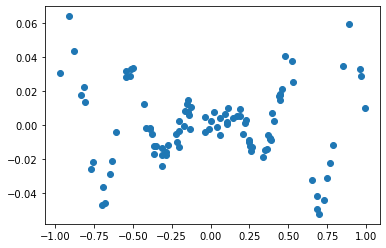

In [4]:
data = np.loadtxt("gp_data.csv", delimiter=",")
X = data[:,:-1]
Y = data[:,-1]
_ = plt.scatter(X,Y)

N = X.shape[0]

## Log verossimilhança

$$ \mathcal{L}(\theta) = -\sum_i \log L_{ii} - \frac{1}{2} \alpha^T \alpha - \frac{N}{2} \log(2 \pi)$$

$$ K + \sigma_y^2 I = L L^T \hspace{0.2cm},\hspace{0.2cm} \alpha = L^{-1}y $$

In [5]:
def log_vero(theta):
    I = np.eye(N)
    
    sigma_f = theta[0]
    w = theta[1:-1]
    sigma_y = theta[-1]
    
    K = K_(X,w,sigma_f)
    
    L = None
    try:
        L = np.linalg.cholesky(K + (sigma_y**2)*I)
    except Exception as e:
        L = np.linalg.cholesky(K + (sigma_y**2)*I + 0.00001*I)
        
    alpha = np.linalg.inv(L).dot(Y)
    
    log = -np.sum(np.log(np.diag(L))) - 0.5*alpha.dot(alpha) - N*np.log(2*np.pi)/2
    
    return log

## Derivada da log-verossimilhança
---

$ \frac{\partial \mathcal{L}(\theta)}{\partial \theta_i} = -\frac{1}{2} Tr(C_N^{-1} \frac{\partial C_N}{\partial \theta_i}) + \frac{1}{2} y^T C_N^{-1} \frac{\partial C_N}{\partial \theta_i} C_N^{-1} y $

$ \theta = [\sigma_f , w, \sigma_y] $

$ C_N = K + \sigma_y^2 I $

### Derivadas de $\theta$

$ \frac{\partial C_N}{\partial \sigma_f} = \frac{\partial K}{\partial \sigma_f} = 2 \sigma_f \exp(-\frac{1}{2} w^2 (x_i - x_j)^2) $

$ \frac{\partial C_N}{\partial w} = \frac{\partial K}{\partial w} = \sigma_f^2 \exp(-\frac{1}{2} w^2 (x_i - x_j)^2) \hspace{.1cm} (-w (x_i - x_j)^2)$

$ \frac{\partial C_N}{\partial \sigma_y} = 2 \sigma_y I $

In [6]:
def derivative_log_vero(theta):
    I = np.eye(N)
    
    sigma_f = theta[0]
    w = theta[1:-1]
    sigma_y = theta[-1]
    
    K = K_(X,w,sigma_f)
    
    Cn = K + (sigma_y**2)*I
    Cn_inv = None
    try:
        Cn_inv = np.linalg.inv(Cn)
    except Exception:
        Cn_inv = np.linalg.inv(Cn + 0.00001*I)
    
    def theta_i_grad(derivative):
        return -0.5*np.trace(Cn_inv.dot(derivative)) +  \
                    0.5*Y.T.dot(Cn_inv).dot(derivative).dot(Cn_inv).dot(Y)
    

    gradients = np.array([
        theta_i_grad(sigma_derivative_K_(X, w, sigma_f)), #derivada de sigma_f
        theta_i_grad(w_derivative_K_(X, w, sigma_f)), #derivada de sigma_w
        theta_i_grad(2*sigma_y*I), #derivada de sigma_y
    ])
    
    return gradients

In [7]:
from scipy.optimize import check_grad
# verificando a implementação do gradiente
check_grad(log_vero, derivative_log_vero, np.array([1,2,0.1]))

4.32557440846061e-05

## Otimizando os hiperparâmetros
---

In [8]:
from scipy.optimize import minimize

def callback(theta): 
    print(f"""sigma_f^2 = {theta[0]**2}
w^2 = {theta[1:-1]**2}
sigma_y^2 = {theta[-1]**2}
log verossimilhança = {log_vero(theta)}
""")

positive_bound = (0, None)
result = minimize(lambda t: (-log_vero(t), -1*derivative_log_vero(t)),
                  np.array([2,100,0.2]),
                  method="L-BFGS-B", 
                  jac=True,
                  callback=callback, 
                  tol=1e-6,
                  bounds=[
                      positive_bound, #sigma_f
                      positive_bound, #w2
                      positive_bound #sigma_y
                  ]
                 )
theta = result.x

print()
print(result.message)
callback(theta)

sigma_f^2 = 0.01496931345519209
w^2 = [9920.47049983]
sigma_y^2 = 0.00014969313455192104
log verossimilhança = 163.20873477976596

sigma_f^2 = 0.0009008344578544196
w^2 = [9858.35487465]
sigma_y^2 = 9.008344578544198e-06
log verossimilhança = 267.5757645782007

sigma_f^2 = 0.0006887012304132613
w^2 = [9296.46395353]
sigma_y^2 = 6.887012304132613e-06
log verossimilhança = 269.51680107708546

sigma_f^2 = 0.0011351676391330868
w^2 = [141.65548877]
sigma_y^2 = 1.1081979889764822e-05
log verossimilhança = 321.767578257303

sigma_f^2 = 0.004108378890002017
w^2 = [121.67450197]
sigma_y^2 = 2.4734528223929275e-05
log verossimilhança = 329.3325519550581

sigma_f^2 = 0.00485832835331688
w^2 = [53.95225834]
sigma_y^2 = 2.8221871903750465e-05
log verossimilhança = 338.9032590638391

sigma_f^2 = 0.005018842281712135
w^2 = [50.43253956]
sigma_y^2 = 2.813264131227913e-05
log verossimilhança = 339.21966007172415

sigma_f^2 = 0.004314348159325068
w^2 = [55.06357347]
sigma_y^2 = 2.5027212772665317e-05
l

## Distribuição preditiva
---

$$ \mu_* = (L^{-1}k_{f*})^T L^{-1} y $$

$$ \sigma^2_* = k_{**} - (L^{-1}k_{f*})^T L^{-1} k_{f*} $$

$$ K + \sigma_y^2 I = L L^T \hspace{0.2cm},\hspace{0.2cm} k_{f*} = [k(x_*, x_1), ..., k(x_*, x_N)]^T \hspace{0.2cm},\hspace{0.2cm} k_{**} = k(x_*, x_*) $$

In [9]:
def predict(x, theta):
    sigma_f = theta[0]
    w = theta[1:-1]
    sigma_y = theta[-1]
    
    I = np.eye(X.shape[0])
    
    K = K_(X,w,sigma_f)
    
    y = []
    v = []
    for x_new in x:
        x_new = x_new.reshape(-1,1)
        k = np.array([rbf(x_new, xi, w, sigma_f) for xi in X])

        L = None
        try:
            L = np.linalg.cholesky(K + (sigma_y**2)*I)
        except Exception as e:
            L = np.linalg.cholesky((K + (sigma_y**2)*I) + 0.00001*I)

        L_inv = np.linalg.inv(L)
        mean = (L_inv.dot(k)).T.dot(L_inv).dot(Y)
        var = (rbf(x_new, x_new, w, sigma_f) - (L_inv.dot(k).T.dot(L_inv).dot(k)))
    
        y.append(mean)
        v.append(var)
        
    return np.array([y, v]).T

In [10]:
from sklearn.metrics import mean_squared_error
def nlpd(y, mean, var, round=None):
    r = 0.5*np.log(2*np.pi) + np.sum(np.log(var) + np.square(y - mean)/var)/(2*y.shape[0])
    if round is None:
        return r
    else:
        return np.round(r,round)

def rmse(y, mean, round=None):
    r = mean_squared_error(y, mean, squared=False)
    if round is None:
        return r
    else:
        return np.round(r,round)

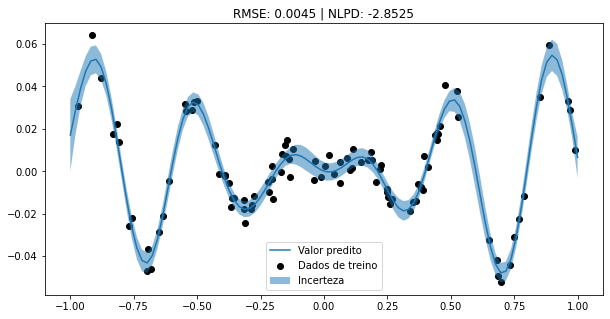

In [11]:
X_test = np.linspace(-1, 1, 100).reshape(-1,1)
predictions = predict(X_test, theta)
y_pred = predictions[:,0]
var = predictions[:,1]
std = np.sqrt(var) * 2

plt.figure(figsize=(10,5))
plt.scatter(X, Y, c='k', label="Dados de treino")
plt.plot(X_test, y_pred, label="Valor predito")
plt.fill_between(X_test[:,0], y_pred+std, y_pred-std, alpha=.5, label="Incerteza")
plt.title(f"RMSE: {rmse(Y, predict(X,theta)[:,0], 4)} | NLPD: {nlpd(Y, predict(X,theta)[:,0], predict(X,theta)[:,1], 4)}")
_ = plt.legend()

## Comparando com o sklearn
---

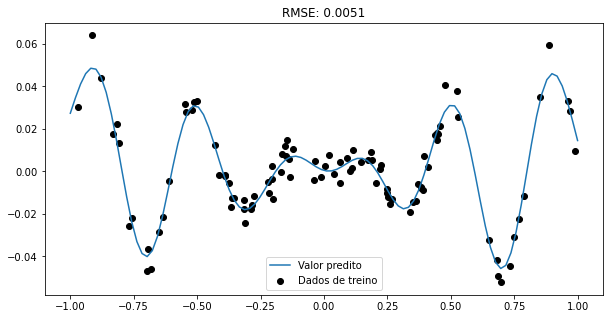

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

# construindo o mesmo kernel, mas fixando os parâmetros para o que foi aprendido
kernel = kernels.ConstantKernel(theta[0], constant_value_bounds="fixed") * kernels.RBF(1/theta[1:-1], length_scale_bounds="fixed") + kernels.WhiteKernel(theta[-1], noise_level_bounds="fixed")

model = GaussianProcessRegressor(kernel = kernel)
model.fit(X,Y)
y_pred = model.predict(X_test)

plt.figure(figsize=(10,5))
plt.scatter(X, Y, c='k', label="Dados de treino")
plt.plot(X_test, y_pred, label="Valor predito")
plt.title(f"RMSE: {rmse(Y, model.predict(X), 4)}")
_ = plt.legend()